# Multi-Layer Perceptron using NumPy

In this HW, we attempt to build a 1-hidden layer multi-layer-perceptron (mlp) from scratch. The notebook has several sections involving training & prediction using mlp's with varying hidden units.

First, we will import all the necessary libraries:

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

We will also generate the required noisy XOR data:

In [ ]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,0.963908,1.108292,0.0
1,0.121986,1.023233,1.0
2,0.975932,0.909002,0.0
3,-0.010511,0.865883,1.0
4,1.000169,0.946251,0.0


Splitting the data into train (80%) and test (20%) sets:

In [ ]:
# set X (training data) and y (target variable)
cols = data.shape[1]

data_train = data.sample(frac=0.8,random_state=234)
data_test = data.drop(data_train.index)

X_train = data_train.iloc[:,0:cols-1]
Y_train = data_train.iloc[:,cols-1:cols]

X_test = data_test.iloc[:,0:cols-1]
Y_test = data_test.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X_train = np.array(X_train.values)
Y_train = np.array(Y_train.values)
X_test = np.array(X_test.values)
Y_test = np.array(Y_test.values)

## (a) Implementation of the Network
We will start by defining the Network as a class, with separate functions for each layer to perform forward/back propagation. Note that since the mlp is restricted to 1 hidden layer, we just need to define functions for the hidden layer and output layer.
<ul>
    <li>Initialization - The network class will have a constructor which can take a variable number of input units, hidden units and output units. The constructor will initialize the weights randomly by using the **np.uniform** method to uniformly draw values between 0,1.</li>
    <li>Forward Propagation - The network class will contain two separate forward prop functions for the hidden/output layers respectively. Each will compute the output Wx+b, and the hidden layer will apply the ReLU non-linearity after the linear output.</li>
    <li>Back Propagation - Similarly, there will be two separate back prop functions, one for each layer. The functions will be used to calculate the gradients of the weights/biases of their respective layers. We are following the notations/formula used in the lecture slides while computing gradients.</li>
    <li>Utility functions - There will also be several utility functions for ReLU, sigmoid, derivative of ReLU, etc.</li>
</ul>

We will first initialize the network with 2 input (since our data has two features), 4 hidden, and 1 output (we are performing binary classification on noisy XOR data) nodes.


In [ ]:
from math import e


class NeuralNetwork:
    #Initiliaze network with random weights/bias between -1,1
    def __init__(self, input_units,hidden_units,output_units):
        print('Initializing Network...')
        self.h_weights = np.random.uniform(0,1,(input_units,hidden_units))
        print('Hidden Layer weights: '+str(self.h_weights))
        self.h_bias = np.random.uniform(0,1,(1,hidden_units))
        print('Hidden Layer bias: '+str(self.h_bias))
        self.out_weights = np.random.uniform(0,1,(hidden_units,output_units))
        print('Output Layer weights: '+str(self.out_weights))
        self.out_bias = np.random.uniform(0,1,(1,output_units))
        print('Output Layer bias: '+str(self.out_bias))

    #Defining the relu function to be used in activations
    @staticmethod
    def relu(x):
        return np.maximum(0,x)
    
    #Defining derivative of relu to be used in gradient calculation
    @staticmethod 
    def drelu(x):
        return 1.0*(x>0)
    
    #Defining the softplus function to be used in loss calculation
    @staticmethod
    def softplus(x):
        return np.log(1+np.power(e,x))
    
    #Defining sigmoid function to be used in gradient calculation
    @staticmethod
    def sigmoid(x):
        return 1/(1+np.power(e,-x))

    def forward_hidden(self, X):
        W = self.h_weights
        b = self.h_bias
        a = np.dot(W.T, X) + b.T 
        return self.relu(a) #Applying relu activation on hidden units
    
    def forward_output(self, X):
        W = self.out_weights
        b = self.out_bias
        a = np.dot(W.T, X) + b.T
        return a #just returning linear output

    def loss_output(self, y_predict, y):
        z = np.multiply((1-(2*y)),y_predict)
        return self.softplus(z)
    
    #Compute gradients of loss function w.r.t parameters of output layer
    def backward_output(self, h, y_predict, y):
        #Compute gradient of Loss w.r.t bias
        #dL/db = (dL/dz)(dz/db) = sigmoid((1-2y)z)(1-2y); here z=y_predict which is the final output
        dL_db = np.multiply((1-(2*y)),y_predict)
        dL_db = self.sigmoid(dL_db)
        dL_db = np.multiply(dL_db, (1-(2*y)))
        dL_db = np.sum(dL_db,axis=1) #Sum gradients to get 1x1
        dL_db = np.expand_dims(dL_db, axis=1)

        #Compute gradient of Loss w.r.t weights
        #dL/dw = (dz/dw)(dL/dz) where h is the output of previous layer
        dL_dw = h*dL_db
        dL_dw = np.sum(dL_dw, axis=1) #Sum gradients to get shape of weight matrix
        dL_dw = np.expand_dims(dL_dw, axis=1)
        
        #return gradients
        return (dL_dw, dL_db)

    #Compute gradients of loss function w.r.t parameters of hidden layer
    def backward_hidden(self, X, h, y_predict, y, dL_dz):
        #Compute gradient of Loss w.r.t bias
        #dL/dc = f(.)dL/dh = f(.)(dL/dz)w
        f = self.drelu(h)
        dL_dc = self.out_weights*dL_dz
        dL_dc = np.multiply(f, dL_dc)
        dL_dc = np.sum(dL_dc, axis=1) #Sum gradients to get shape of bias
        dL_dc = np.expand_dims(dL_dc, axis=1)

        #Compute gradient of Loss w.r.t weights
        #dL/dW = x(f(.)dL/dh)
        dL_dW = self.out_weights*dL_dz
        dL_dW = np.multiply(f, dL_dc)
        dL_dW = np.dot(X, dL_dW.T)
        
        return (dL_dW, dL_dc)
    
    
np.random.seed(432)
mlp = NeuralNetwork(2,4,1)

Initializing Network...
Hidden Layer weights: [[0.90366057 0.89601028 0.58995011 0.98727338]
 [0.8516035  0.20881651 0.76662286 0.03280564]]
Hidden Layer bias: [[0.29674602 0.57035959 0.83466854 0.16072966]]
Output Layer weights: [[0.34841114]
 [0.03089059]
 [0.98635311]
 [0.50147651]]
Output Layer bias: [[0.43779437]]


## (b) Training the Network
We will start by splitting the training set into batches. We will be taking a batch size of 8 for this task:

In [ ]:
#Converting input into batches
batch_size = 8

q = X_train.shape[0] // batch_size
block_end = q * batch_size

X_batches = np.split(X_train[:block_end], q) + [X_train[block_end:]]
Y_batches = np.split(Y_train[:block_end], q) + [Y_train[block_end:]]
print(X_batches[:1])
print(Y_batches[:1])

[array([[ 0.12658385, -0.09000993],
       [ 0.99243011,  1.15784494],
       [ 0.05665893,  0.96554498],
       [ 1.11959482,  0.91013086],
       [-0.24282341,  0.18516895],
       [-0.09402467,  0.81748403],
       [ 0.04930543,  1.28038272],
       [ 0.11205034,  0.91394862]])]
[array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.]])]


To make sure our functions are working as expected, we will test the forward & backward pass on 1 batch:

In [ ]:
#1 Forward prop/ Back prop example with 1 batch:
for indx,x_batch in enumerate(X_batches[:1]):
    print('Forward Prop: \n')
    print('Input shape: '+str(x_batch.T.shape))
    h = mlp.forward_hidden(x_batch.T)
    print('Hidden Layer outputs: ')
    print(h)
    print('Hidden Layer output shape: ')
    print(h.shape)
    y_predict = mlp.forward_output(h)
    print('Final Layer outputs: ')
    print(y_predict)
    print('Final Layer output shape: ')
    print(y_predict.shape)

    print('Back Prop: \n')
    loss = mlp.loss_output(y_predict,Y_batches[indx].T)
    print('Losses: ')
    print(loss)
    
    (dw, db) = mlp.backward_output(h,y_predict,Y_batches[indx].T)
    print('db shape: '+str(db.shape))
    print('dw shape: '+str(dw.shape))
    (dW, dc) = mlp.backward_hidden(x_batch.T, h, y_predict, Y_batches[indx].T,dL_dz=db)
    print('dc shape: '+str(dc.shape))
    print('dW shape: '+str(dW.shape))

print('Done...')


Forward Prop: 

Input shape: (2, 8)
Hidden Layer outputs: 
[[0.33448209 2.17959078 1.17020794 2.08355034 0.2350066  0.9079519
  1.4316798  1.17632334]
 [0.66498446 1.70136431 0.82274831 1.76357841 0.39145365 0.65681669
  0.88190282 0.86160541]
 [0.84034303 2.30778318 1.60830333 2.19290074 0.83336959 1.40590062
  1.84532694 1.60142655]
 [0.28274969 1.17851332 0.24834283 1.29593324 0.         0.09471969
  0.25141137 0.30133664]]
Hidden Layer output shape: 
(4, 8)
Final Layer outputs: 
[[1.54554071 4.1170301  2.58181612 4.03105905 1.35376221 2.20863853
  2.91007092 2.60493933]]
Final Layer output shape: 
(1, 8)
Back Prop: 

Losses: 
[[1.73879937 4.13319162 0.07291259 4.04865877 1.58349741 0.10422497
  0.05304004 0.07130398]]
db shape: (1, 1)
dw shape: (4, 1)
dc shape: (4, 1)
dW shape: (2, 4)
Done...


Now, we can finally train the network. We will write a simple loop to perform the gradient calculation and updates for each mini-batch. We will take an initial learning rate of $10^{-3}$ and train for 40 epochs. We will calculate the loss after every epoch by averaging across the total number of training samples and plot the loss vs epoch curve:

Training epoch 0...
Loss: [0.69496051]
Training epoch 1...
Loss: [0.63307524]
Training epoch 2...
Loss: [0.54003879]
Training epoch 3...
Loss: [0.42172356]
Training epoch 4...
Loss: [0.31011005]
Training epoch 5...
Loss: [0.22651884]
Training epoch 6...
Loss: [0.17154086]
Training epoch 7...
Loss: [0.13617047]
Training epoch 8...
Loss: [0.11292022]
Training epoch 9...
Loss: [0.0969987]
Training epoch 10...
Loss: [0.08558807]
Training epoch 11...
Loss: [0.07711486]
Training epoch 12...
Loss: [0.07061106]
Training epoch 13...
Loss: [0.06546378]
Training epoch 14...
Loss: [0.06139045]
Training epoch 15...
Loss: [0.05808958]
Training epoch 16...
Loss: [0.05530889]
Training epoch 17...
Loss: [0.05296251]
Training epoch 18...
Loss: [0.05095401]
Training epoch 19...
Loss: [0.0493289]
Training epoch 20...
Loss: [0.04794952]
Training epoch 21...
Loss: [0.04675611]
Training epoch 22...
Loss: [0.04574959]
Training epoch 23...
Loss: [0.04486971]
Training epoch 24...
Loss: [0.04406196]
Training epo

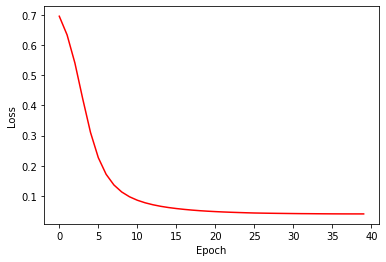

In [ ]:
#Training the network
epochs = 40
learning_rate = 1e-3

#Training the network with mini-batch s.g.c.
epoch_losses = []
for iteration in range(epochs):
    loss_epoch = 0
    print('Training epoch '+str(iteration)+'...')
    for indx,x_batch in enumerate(X_batches[:]):
        #Forward pass:
        h = mlp.forward_hidden(x_batch.T)
        y_predict = mlp.forward_output(h)
        loss = mlp.loss_output(y_predict, Y_batches[indx].T)
        loss = np.sum(loss, axis=1)
        loss_epoch += loss
        #Backward pass:
        (dw, db) = mlp.backward_output(h,y_predict,Y_batches[indx].T)
        (dW, dc) = mlp.backward_hidden(x_batch.T, h, y_predict, Y_batches[indx].T,dL_dz=db)
        #Update parameters of network for each batch
        mlp.out_bias = mlp.out_bias - learning_rate*(db)
        mlp.out_weights = mlp.out_weights - learning_rate*(dw)
        mlp.h_bias = mlp.h_bias - learning_rate*(dc.T)
        mlp.h_weights = mlp.h_weights - learning_rate*(dW)
    
    loss_epoch /= data_train.shape[0] #Average loss after each epoch
    print('Loss: '+str(loss_epoch))
    epoch_losses.append(loss_epoch)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epochs),epoch_losses,color="red")
plt.show()

So our model seems to have fit the training data after ~25 epochs, after which not much change in loss occurred. Now, we will perform the predictions on the test set:  

In [ ]:
#Predicting on test set
h_test = mlp.forward_hidden(X_test.T)
test_predictions = mlp.forward_output(h_test)
test_predictions = 1*(test_predictions>0)
correct = 0
for indx,test_prediction in enumerate(test_predictions.T):
    if(float(test_prediction)==Y_test[indx]):
        correct += 1
accuracy = correct/Y_test.shape[0]
print('Test Accuracy: '+str(accuracy))


Test Accuracy: 0.991


We have achieved a modest accuracy of ~98% for the noisy XOR data using a simple 1-hidden layer mlp, with 4 hidden nodes.

## (c) Visualizing the decision boundary

Now, we can visualize the decision boundary of the trained model by generating a large number of points (say 10k) and predicting the class of these points:

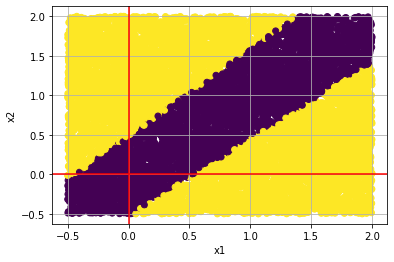

In [ ]:
#Creating dummy data to visualize the decision boundary of the mlp
dummy_data_np = np.random.uniform(-.5,2.,(10000,2))
#Predictions on dummy data
h_dummy = mlp.forward_hidden(dummy_data_np.T)
dummy_predictions = mlp.forward_output(h_dummy)
dummy_predictions = 1*(dummy_predictions>0)

plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(dummy_data_np[:,0],dummy_data_np[:,1],c=dummy_predictions)
plt.axvline(x=0, c="red")
plt.axhline(y=0, c="red")
plt.grid()
plt.show()

## (d) Repeating with different number of hidden units
Now we will repeat the classification task with varying units in the hidden layer (3, 16, 512):

In [ ]:
#Initializing different networks
np.random.seed(495)
#3 hidden units:
mlp_3_units = NeuralNetwork(2, 3, 1)
#16 hidden units:
mlp_16_units = NeuralNetwork(2, 16, 1)
#512 hidden units:
mlp_512_units = NeuralNetwork(2, 512, 1)

Initializing Network...
Hidden Layer weights: [[0.2880632  0.98149882 0.7493026 ]
 [0.51873716 0.55116564 0.65433476]]
Hidden Layer bias: [[0.96108324 0.50711907 0.86270915]]
Output Layer weights: [[0.75467917]
 [0.66978572]
 [0.74673414]]
Output Layer bias: [[0.60582536]]
Initializing Network...
Hidden Layer weights: [[0.24940276 0.14888213 0.7062548  0.5601043  0.47926556 0.2589231
  0.24926721 0.66030285 0.88502846 0.69834282 0.30451048 0.49290273
  0.25975769 0.52200325 0.16989959 0.79620314]
 [0.05287952 0.10969771 0.8906775  0.6728608  0.75043905 0.31711648
  0.2305891  0.41225405 0.67682093 0.30833645 0.85844423 0.82594279
  0.98057742 0.1452637  0.5530945  0.31493988]]
Hidden Layer bias: [[0.61453324 0.75216869 0.54121795 0.5575133  0.49614936 0.55465487
  0.43429906 0.53601845 0.76709797 0.62919236 0.00906167 0.35329904
  0.08801573 0.84526638 0.43499622 0.73094403]]
Output Layer weights: [[0.2339228 ]
 [0.16715117]
 [0.87487747]
 [0.47547358]
 [0.79741763]
 [0.03107626]
 [0.4

Now we will train the networks using the same training set, in batches of 8:

Training epoch 0...
Loss: [0.71965101]
Training epoch 1...
Loss: [0.62972138]
Training epoch 2...
Loss: [0.59422164]
Training epoch 3...
Loss: [0.57270163]
Training epoch 4...
Loss: [0.55702177]
Training epoch 5...
Loss: [0.54467944]
Training epoch 6...
Loss: [0.53479227]
Training epoch 7...
Loss: [0.52652203]
Training epoch 8...
Loss: [0.51961781]
Training epoch 9...
Loss: [0.51418807]
Training epoch 10...
Loss: [0.50997896]
Training epoch 11...
Loss: [0.50670778]
Training epoch 12...
Loss: [0.50397729]
Training epoch 13...
Loss: [0.50154056]
Training epoch 14...
Loss: [0.4990109]
Training epoch 15...
Loss: [0.49659461]
Training epoch 16...
Loss: [0.49447469]
Training epoch 17...
Loss: [0.49303828]
Training epoch 18...
Loss: [0.49199144]
Training epoch 19...
Loss: [0.49097668]
Training epoch 20...
Loss: [0.48996302]
Training epoch 21...
Loss: [0.4890726]
Training epoch 22...
Loss: [0.48799984]
Training epoch 23...
Loss: [0.48706474]
Training epoch 24...
Loss: [0.48643393]
Training epo

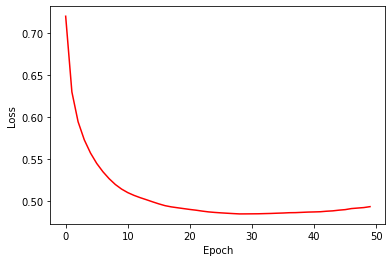

In [ ]:
epochs = 50
learning_rate = 1e-3

#Training the 3-hidden-unit network
epoch_losses_mlp_3 = []
for iteration in range(epochs):
    loss_epoch = 0
    print('Training epoch '+str(iteration)+'...')
    for indx,x_batch in enumerate(X_batches[:]):
        h = mlp_3_units.forward_hidden(x_batch.T)
        y_predict = mlp_3_units.forward_output(h)
        loss = mlp_3_units.loss_output(y_predict, Y_batches[indx].T)
        loss = np.sum(loss, axis=1)
        loss_epoch += loss
        (dw, db) = mlp_3_units.backward_output(h,y_predict,Y_batches[indx].T)
        (dW, dc) = mlp_3_units.backward_hidden(x_batch.T, h, y_predict, Y_batches[indx].T,dL_dz=db)
        #Update parameters of network for each batch
        mlp_3_units.out_bias = mlp_3_units.out_bias - learning_rate*(db)
        mlp_3_units.out_weights = mlp_3_units.out_weights - learning_rate*(dw)
        mlp_3_units.h_bias = mlp_3_units.h_bias - learning_rate*(dc.T)
        mlp_3_units.h_weights = mlp_3_units.h_weights - learning_rate*(dW)
    
    loss_epoch /= data_train.shape[0] #Average loss after each epoch
    print('Loss: '+str(loss_epoch))
    epoch_losses_mlp_3.append(loss_epoch)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epochs),epoch_losses_mlp_3,color="red")
plt.show()

Training epoch 0...
Loss: [0.66748124]
Training epoch 1...
Loss: [0.48341151]
Training epoch 2...
Loss: [0.34426772]
Training epoch 3...
Loss: [0.24077257]
Training epoch 4...
Loss: [0.17625257]
Training epoch 5...
Loss: [0.13662606]
Training epoch 6...
Loss: [0.11132789]
Training epoch 7...
Loss: [0.09441925]
Training epoch 8...
Loss: [0.08244238]
Training epoch 9...
Loss: [0.07363544]
Training epoch 10...
Loss: [0.06689583]
Training epoch 11...
Loss: [0.06152039]
Training epoch 12...
Loss: [0.05713193]
Training epoch 13...
Loss: [0.05361034]
Training epoch 14...
Loss: [0.05064889]
Training epoch 15...
Loss: [0.04811932]
Training epoch 16...
Loss: [0.04589813]
Training epoch 17...
Loss: [0.04403817]
Training epoch 18...
Loss: [0.04245434]
Training epoch 19...
Loss: [0.04112766]
Training epoch 20...
Loss: [0.03988569]
Training epoch 21...
Loss: [0.03878641]
Training epoch 22...
Loss: [0.03778445]
Training epoch 23...
Loss: [0.03697894]
Training epoch 24...
Loss: [0.03618138]
Training e

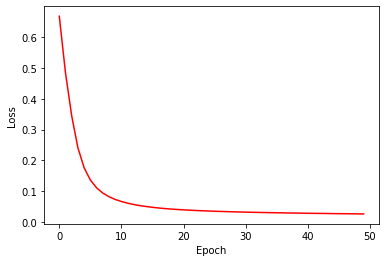

In [ ]:
#Training the 16-hidden-unit network
epoch_losses_mlp_16 = []
for iteration in range(epochs):
    loss_epoch = 0
    print('Training epoch '+str(iteration)+'...')
    for indx,x_batch in enumerate(X_batches[:]):
        h = mlp_16_units.forward_hidden(x_batch.T)
        y_predict = mlp_16_units.forward_output(h)
        loss = mlp_16_units.loss_output(y_predict, Y_batches[indx].T)
        loss = np.sum(loss, axis=1)
        loss_epoch += loss
        (dw, db) = mlp_16_units.backward_output(h,y_predict,Y_batches[indx].T)
        (dW, dc) = mlp_16_units.backward_hidden(x_batch.T, h, y_predict, Y_batches[indx].T,dL_dz=db)
        #Update parameters of network for each batch
        mlp_16_units.out_bias = mlp_16_units.out_bias - learning_rate*(db)
        mlp_16_units.out_weights = mlp_16_units.out_weights - learning_rate*(dw)
        mlp_16_units.h_bias = mlp_16_units.h_bias - learning_rate*(dc.T)
        mlp_16_units.h_weights = mlp_16_units.h_weights - learning_rate*(dW)
    
    loss_epoch /= data_train.shape[0] #Average loss after each epoch
    print('Loss: '+str(loss_epoch))
    epoch_losses_mlp_16.append(loss_epoch)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epochs),epoch_losses_mlp_16,color="red")
plt.show()

Training epoch 0...
Loss: [2.91463395]
Training epoch 1...
Loss: [0.11941666]
Training epoch 2...
Loss: [0.08453948]
Training epoch 3...
Loss: [0.0704821]
Training epoch 4...
Loss: [0.06250108]
Training epoch 5...
Loss: [0.05734252]
Training epoch 6...
Loss: [0.05358343]
Training epoch 7...
Loss: [0.05074085]
Training epoch 8...
Loss: [0.04851067]
Training epoch 9...
Loss: [0.04677147]
Training epoch 10...
Loss: [0.04531979]
Training epoch 11...
Loss: [0.04409453]
Training epoch 12...
Loss: [0.04312878]
Training epoch 13...
Loss: [0.04241011]
Training epoch 14...
Loss: [0.04193931]
Training epoch 15...
Loss: [0.04154536]
Training epoch 16...
Loss: [0.04138549]
Training epoch 17...
Loss: [0.04118353]
Training epoch 18...
Loss: [0.0410044]
Training epoch 19...
Loss: [0.04086407]
Training epoch 20...
Loss: [0.04067871]
Training epoch 21...
Loss: [0.04064043]
Training epoch 22...
Loss: [0.04056609]
Training epoch 23...
Loss: [0.04050626]
Training epoch 24...
Loss: [0.04052221]
Training epo

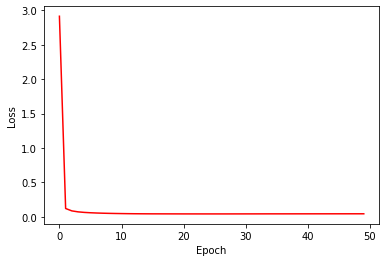

In [ ]:
#Training the 512-hidden-unit network
epoch_losses_mlp_512 = []
for iteration in range(epochs):
    loss_epoch = 0
    print('Training epoch '+str(iteration)+'...')
    for indx,x_batch in enumerate(X_batches[:]):
        h = mlp_512_units.forward_hidden(x_batch.T)
        y_predict = mlp_512_units.forward_output(h)
        loss = mlp_512_units.loss_output(y_predict, Y_batches[indx].T)
        loss = np.sum(loss, axis=1)
        loss_epoch += loss
        (dw, db) = mlp_512_units.backward_output(h,y_predict,Y_batches[indx].T)
        (dW, dc) = mlp_512_units.backward_hidden(x_batch.T, h, y_predict, Y_batches[indx].T,dL_dz=db)
        #Update parameters of network for each batch
        mlp_512_units.out_bias = mlp_512_units.out_bias - learning_rate*(db)
        mlp_512_units.out_weights = mlp_512_units.out_weights - learning_rate*(dw)
        mlp_512_units.h_bias = mlp_512_units.h_bias - learning_rate*(dc.T)
        mlp_512_units.h_weights = mlp_512_units.h_weights - learning_rate*(dW)
    
    loss_epoch /= data_train.shape[0] #Average loss after each epoch
    print('Loss: '+str(loss_epoch))
    epoch_losses_mlp_512.append(loss_epoch)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epochs),epoch_losses_mlp_512,color="red")
plt.show()

Now that the models have finished training, we can compare the accuracy of them on the test set:

In [ ]:
#Predicting the test set for the three models to compare accuracy

#3-unit mlp
h_test_mlp3 = mlp_3_units.forward_hidden(X_test.T)
test_predictions_mlp3 = mlp_3_units.forward_output(h_test_mlp3)
test_predictions_mlp3 = 1*(test_predictions_mlp3>0)
correct = 0
for indx,test_prediction in enumerate(test_predictions_mlp3.T):
    if(float(test_prediction)==Y_test[indx]):
        correct += 1
accuracy = correct/Y_test.shape[0]
print('Test Accuracy for mlp with 3 hidden units: '+str(accuracy))

#16-unit mlp
h_test_mlp16 = mlp_16_units.forward_hidden(X_test.T)
test_predictions_mlp16 = mlp_16_units.forward_output(h_test_mlp16)
test_predictions_mlp16 = 1*(test_predictions_mlp16>0)
correct = 0
for indx,test_prediction in enumerate(test_predictions_mlp16.T):
    if(float(test_prediction)==Y_test[indx]):
        correct += 1
accuracy = correct/Y_test.shape[0]
print('Test Accuracy for mlp with 16 hidden units: '+str(accuracy))

#512-unit mlp
h_test_mlp512 = mlp_512_units.forward_hidden(X_test.T)
test_predictions_mlp512 = mlp_512_units.forward_output(h_test_mlp512)
test_predictions_mlp512 = 1*(test_predictions_mlp512>0)
correct = 0
for indx,test_prediction in enumerate(test_predictions_mlp512.T):
    if(float(test_prediction)==Y_test[indx]):
        correct += 1
accuracy = correct/Y_test.shape[0]
print('Test Accuracy for mlp with 512 hidden units: '+str(accuracy))

Test Accuracy for mlp with 3 hidden units: 0.734
Test Accuracy for mlp with 16 hidden units: 0.997
Test Accuracy for mlp with 512 hidden units: 0.994


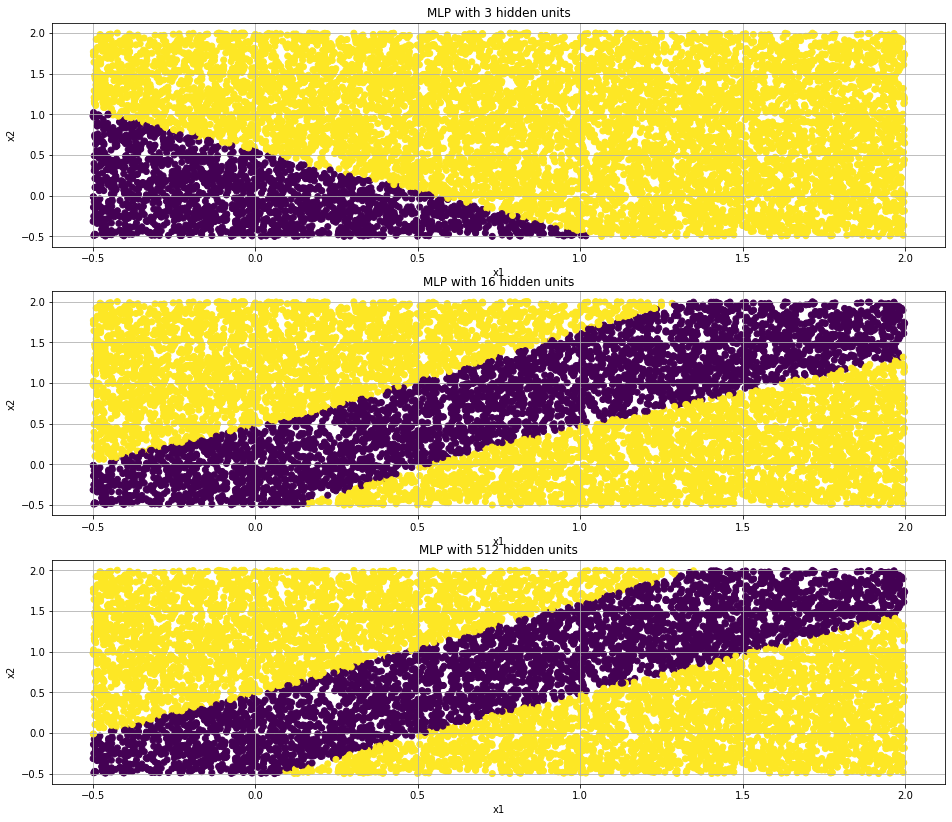

In [ ]:
#Plotting the decision boundary using the 10k dummy points we generated earlier:
dummy_predictions_mlp3 = mlp_3_units.forward_output(mlp_3_units.forward_hidden(dummy_data_np.T))
dummy_predictions_mlp16 = mlp_16_units.forward_output(mlp_16_units.forward_hidden(dummy_data_np.T))
dummy_predictions_mlp512 = mlp_512_units.forward_output(mlp_512_units.forward_hidden(dummy_data_np.T))
dummy_predictions_mlp3 = 1*(dummy_predictions_mlp3>0)
dummy_predictions_mlp16 = 1*(dummy_predictions_mlp16>0)
dummy_predictions_mlp512 = 1*(dummy_predictions_mlp512>0)

fig,ax = plt.subplots(3, figsize=(16,14))
ax[0].set_title('MLP with 3 hidden units')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].scatter(dummy_data_np[:,0],dummy_data_np[:,1],c=dummy_predictions_mlp3)

ax[1].set_title('MLP with 16 hidden units')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[1].scatter(dummy_data_np[:,0],dummy_data_np[:,1],c=dummy_predictions_mlp16)

ax[2].set_title('MLP with 512 hidden units')
ax[2].set_xlabel('x1')
ax[2].set_ylabel('x2')
ax[2].scatter(dummy_data_np[:,0],dummy_data_np[:,1],c=dummy_predictions_mlp512)
ax[0].grid()
ax[1].grid()
ax[2].grid()

plt.show()

#### Results:
As we increase the number of hidden units, the boundary starts to become more complex, eventually overfitting the training data. The model with 3 hidden units only achieves 75% accuracy and is unable to map the noisy XOR function accurately.

## (e) Repeat (d) using a different loss function
We will repeat the exercise using mean-squared error loss since our output z can contain negative values. We will apply MSE on the sigmoid of the output of the final layer (z): <br><br>
$L = \frac{1}{2}(y-\sigma(z))^2$ <br><br>
So the partial derivative of the loss function w.r.t output z will become:<br><br>
$\frac{dL}{dz} = (y-\sigma(z))(-\sigma'(z))$<br><br>
Where $\sigma'(z)$ is the derivative of the sigmoid function w.r.t z:<br><br>
$\sigma'(z) = \sigma(z)(1-\sigma(z))$

We will define a new class that inherits the previous NeuralNetwork class, and uses MSE loss. The backprop function for the output layer will be appropriately overriden because the gradient calculation is now different (according to the formulae above):

In [ ]:
#Neural Network class with binary cross-entropy (log loss)
class NeuralNetwork_with_mse(NeuralNetwork):

    #Derivative of sigmoid function w.r.t z to be used in gradient calculation
    @staticmethod
    def dsigmoid(x):
        return NeuralNetwork.sigmoid(x)*(1-NeuralNetwork.sigmoid(x))

    #Override loss function with mean squared error
    def loss_output(self, y_predict, y):
        loss = (np.power(self.sigmoid(y_predict)-y, 2))*(0.5)
        return loss
    
    #Derivative of mse loss function w.r.t to output z (to be used in gradient calculation)
    @staticmethod
    def dmse(y_predict, y):
        dL = (y-NeuralNetwork_with_mse.sigmoid(y_predict))*(-1*NeuralNetwork_with_mse.dsigmoid(y_predict))
        return dL
    
    #Override backward method for output layer since the loss function is different
    def backward_output(self, h, y_predict, y):
        #Compute gradient of Loss w.r.t bias
        #dL/db = (dL/dz)(dz/db) = (dL/dz)*1 = (derivative of logloss w.r.t z); here z=y_predict which is the final output
        dL_db = self.dmse(y_predict, y)
        dL_db = np.sum(dL_db,axis=1) #Sum gradients to get 1x1
        dL_db = np.expand_dims(dL_db, axis=1)

        #Compute gradient of Loss w.r.t weights
        #dL/dw = (dz/dw)(dL/dz) where h is the output of previous layer
        dL_dw = h*dL_db
        dL_dw = np.sum(dL_dw, axis=1) #Sum gradients to get shape of weight matrix
        dL_dw = np.expand_dims(dL_dw, axis=1)
        
        #return gradients
        return (dL_dw, dL_db)
    
    #Defining a model.fit() function to perform training (mini-batch gradient descent)
    def fit(self, X_batches, Y_batches, epochs, learning_rate):
        epoch_losses = []
        for iteration in range(epochs):
            loss_epoch = 0
            print('Training epoch '+str(iteration)+'...')
            for indx,x_batch in enumerate(X_batches[:]):
                #Forward pass
                h = self.forward_hidden(x_batch.T)
                y_predict = self.forward_output(h)
                loss = self.loss_output(y_predict, Y_batches[indx].T)                
                loss = np.sum(loss, axis=1)
                loss_epoch += loss
                #Backward pass
                (dw, db) = self.backward_output(h,y_predict,Y_batches[indx].T)
                (dW, dc) = self.backward_hidden(x_batch.T, h, y_predict, Y_batches[indx].T,dL_dz=db)
                #Update parameters of network for each batch
                self.out_bias = self.out_bias - learning_rate*(db)
                self.out_weights = self.out_weights - learning_rate*(dw)
                self.h_bias = self.h_bias - learning_rate*(dc.T)
                self.h_weights = self.h_weights - learning_rate*(dW)
            
            loss_epoch /= data_train.shape[0] #Average loss after each epoch
            print('Loss: '+str(loss_epoch))
            epoch_losses.append(loss_epoch)

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(range(epochs),epoch_losses,color="red")
        plt.show()


Now, we will initialize the MLPs with varying number of hidden units:

In [ ]:
#Initialzing the mlps with different # of hidden units
mlp_mse_3_units = NeuralNetwork_with_mse(2,3,1)
mlp_mse_16_units = NeuralNetwork_with_mse(2,16,1)
mlp_mse_512_units = NeuralNetwork_with_mse(2,512,1)

Initializing Network...
Hidden Layer weights: [[0.08430807 0.46159887 0.6418603 ]
 [0.21867966 0.52850981 0.32447158]]
Hidden Layer bias: [[0.94288419 0.49135528 0.48782095]]
Output Layer weights: [[0.25254301]
 [0.63786666]
 [0.09414964]]
Output Layer bias: [[0.26147597]]
Initializing Network...
Hidden Layer weights: [[0.46555259 0.7640901  0.47588162 0.00186132 0.60318709 0.19477537
  0.8470546  0.43878702 0.27909449 0.87927577 0.43520941 0.23967768
  0.31577747 0.15520953 0.62180103 0.93617429]
 [0.91746905 0.39920283 0.78434988 0.50222244 0.21704589 0.1092019
  0.86497158 0.16165891 0.07180569 0.12898711 0.32169297 0.94222255
  0.64083257 0.05944408 0.95717401 0.62228984]]
Hidden Layer bias: [[0.663542   0.43853367 0.00636456 0.96123556 0.4045202  0.1893462
  0.87757515 0.60543693 0.14588594 0.58803672 0.80087565 0.354053
  0.45147242 0.38768051 0.87761576 0.317929  ]]
Output Layer weights: [[0.69221029]
 [0.47150159]
 [0.9414558 ]
 [0.62083868]
 [0.80982282]
 [0.84404986]
 [0.6188

Finally, we will train the MLPs on the same training set. We are now training for 100 epochs and with a learning rate of 10^-2.

Training epoch 0...
Loss: [0.12217836]
Training epoch 1...
Loss: [0.09139573]
Training epoch 2...
Loss: [0.06221572]
Training epoch 3...
Loss: [0.04556577]
Training epoch 4...
Loss: [0.0379205]
Training epoch 5...
Loss: [0.03297493]
Training epoch 6...
Loss: [0.02909351]
Training epoch 7...
Loss: [0.02602298]
Training epoch 8...
Loss: [0.02358002]
Training epoch 9...
Loss: [0.02151142]
Training epoch 10...
Loss: [0.0198422]
Training epoch 11...
Loss: [0.01835578]
Training epoch 12...
Loss: [0.01708247]
Training epoch 13...
Loss: [0.01596274]
Training epoch 14...
Loss: [0.01504431]
Training epoch 15...
Loss: [0.01421151]
Training epoch 16...
Loss: [0.01336909]
Training epoch 17...
Loss: [0.01273864]
Training epoch 18...
Loss: [0.01209335]
Training epoch 19...
Loss: [0.01147716]
Training epoch 20...
Loss: [0.01098341]
Training epoch 21...
Loss: [0.01050319]
Training epoch 22...
Loss: [0.01005244]
Training epoch 23...
Loss: [0.00964736]
Training epoch 24...
Loss: [0.00928255]
Training epo

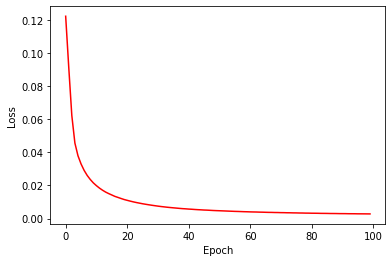

Training epoch 0...
Loss: [0.12884058]
Training epoch 1...
Loss: [0.06576485]
Training epoch 2...
Loss: [0.03239318]
Training epoch 3...
Loss: [0.01710007]
Training epoch 4...
Loss: [0.0103001]
Training epoch 5...
Loss: [0.00731897]
Training epoch 6...
Loss: [0.00576234]
Training epoch 7...
Loss: [0.00484761]
Training epoch 8...
Loss: [0.00425057]
Training epoch 9...
Loss: [0.00382946]
Training epoch 10...
Loss: [0.00350285]
Training epoch 11...
Loss: [0.00326262]
Training epoch 12...
Loss: [0.00307941]
Training epoch 13...
Loss: [0.00292263]
Training epoch 14...
Loss: [0.00279284]
Training epoch 15...
Loss: [0.00267898]
Training epoch 16...
Loss: [0.00258236]
Training epoch 17...
Loss: [0.00251441]
Training epoch 18...
Loss: [0.00244536]
Training epoch 19...
Loss: [0.00239781]
Training epoch 20...
Loss: [0.00234754]
Training epoch 21...
Loss: [0.0022969]
Training epoch 22...
Loss: [0.00226169]
Training epoch 23...
Loss: [0.00222079]
Training epoch 24...
Loss: [0.00218374]
Training epo

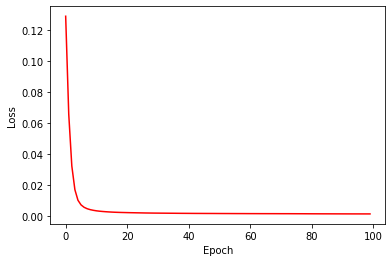

Training epoch 0...
Loss: [0.249875]
Training epoch 1...
Loss: [0.249875]
Training epoch 2...
Loss: [0.249875]
Training epoch 3...
Loss: [0.249875]
Training epoch 4...
Loss: [0.249875]
Training epoch 5...
Loss: [0.249875]
Training epoch 6...
Loss: [0.249875]
Training epoch 7...
Loss: [0.249875]
Training epoch 8...
Loss: [0.249875]
Training epoch 9...
Loss: [0.249875]
Training epoch 10...
Loss: [0.249875]
Training epoch 11...
Loss: [0.249875]
Training epoch 12...
Loss: [0.249875]
Training epoch 13...
Loss: [0.249875]
Training epoch 14...
Loss: [0.249875]
Training epoch 15...
Loss: [0.249875]
Training epoch 16...
Loss: [0.249875]
Training epoch 17...
Loss: [0.249875]
Training epoch 18...
Loss: [0.249875]
Training epoch 19...
Loss: [0.249875]
Training epoch 20...
Loss: [0.249875]
Training epoch 21...
Loss: [0.249875]
Training epoch 22...
Loss: [0.249875]
Training epoch 23...
Loss: [0.249875]
Training epoch 24...
Loss: [0.249875]
Training epoch 25...
Loss: [0.249875]
Training epoch 26...
L

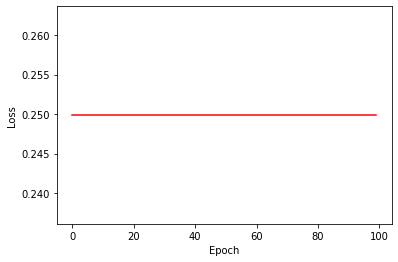

In [ ]:
#Training the networks
epochs = 100
learning_rate = 1e-2
mlp_mse_3_units.fit(X_batches, Y_batches, epochs, learning_rate)
mlp_mse_16_units.fit(X_batches, Y_batches, epochs, learning_rate)
mlp_mse_512_units.fit(X_batches, Y_batches, epochs, learning_rate)


We can also plot the decision boundary of the MLPs using MSE loss:

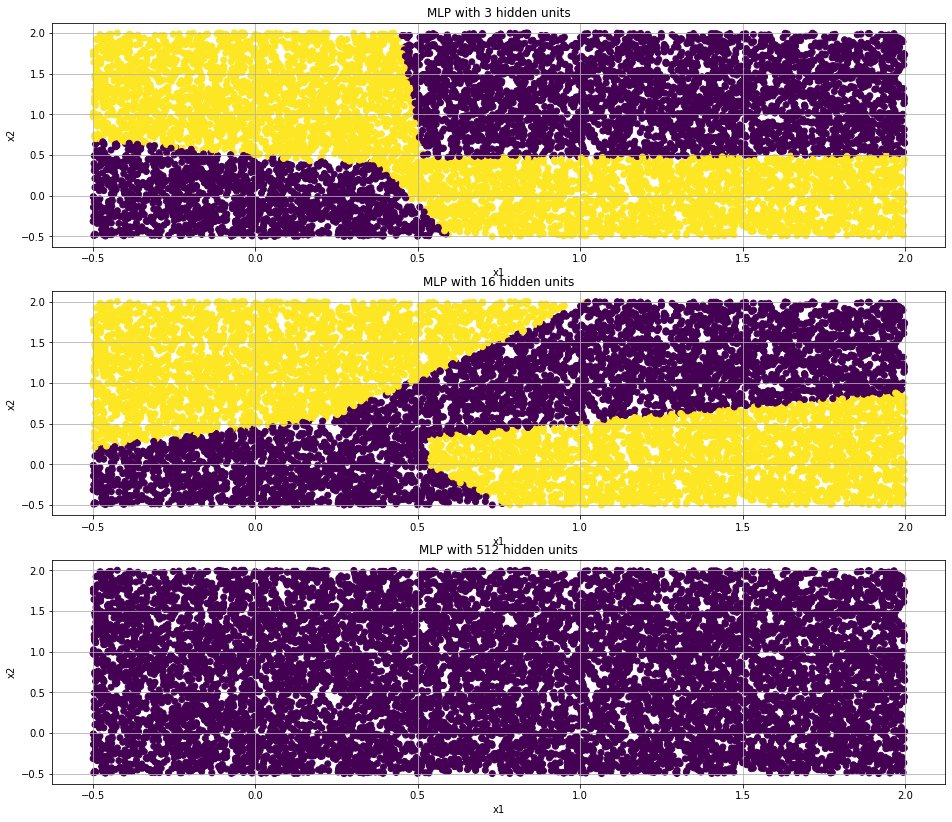

In [ ]:
#Plotting the decision boundary using the 10k dummy points we generated earlier:
dummy_predictions_mlp3_mse = mlp_mse_3_units.forward_output(mlp_mse_3_units.forward_hidden(dummy_data_np.T))
dummy_predictions_mlp16_mse = mlp_mse_16_units.forward_output(mlp_mse_16_units.forward_hidden(dummy_data_np.T))
dummy_predictions_mlp512_mse = mlp_mse_512_units.forward_output(mlp_mse_512_units.forward_hidden(dummy_data_np.T))
dummy_predictions_mlp3_mse = 1*(dummy_predictions_mlp3_mse>0)
dummy_predictions_mlp16_mse = 1*(dummy_predictions_mlp16_mse>0)
dummy_predictions_mlp512_mse = 1*(dummy_predictions_mlp512_mse>0)

fig,ax = plt.subplots(3, figsize=(16,14))
ax[0].set_title('MLP with 3 hidden units')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].scatter(dummy_data_np[:,0],dummy_data_np[:,1],c=dummy_predictions_mlp3_mse)

ax[1].set_title('MLP with 16 hidden units')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[1].scatter(dummy_data_np[:,0],dummy_data_np[:,1],c=dummy_predictions_mlp16_mse)

ax[2].set_title('MLP with 512 hidden units')
ax[2].set_xlabel('x1')
ax[2].set_ylabel('x2')
ax[2].scatter(dummy_data_np[:,0],dummy_data_np[:,1],c=dummy_predictions_mlp512_mse)
ax[0].grid()
ax[1].grid()
ax[2].grid()

plt.show()

#### Results:
The 3 and 16 node MLP was able to train on the points and come up with decision boundaries with the skewed hourglass shapes. The MLP which used 512 nodes with mse loss was not able to train due to the values becoming exponentially small.

## (f) Classification of 3-D Noisy XOR data
We will now generate noisy XOR data in 3 dimensions. After this, we will initialize and train a MLP that uses the softplus loss (as defined in the NeuralNetwork() class)

In [ ]:
#Generating 3-D noisy XOR data:
data_3d = pd.DataFrame(np.zeros((5000, 4)), columns=['x1', 'x2', 'x3', 'y'])

for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    x3 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(np.logical_xor(x1==1, x2==1), x3==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    x3 = x3 + 0.15 * np.random.normal()
    data_3d.iloc[i,0] = x1
    data_3d.iloc[i,1] = x2
    data_3d.iloc[i,2] = x3
    data_3d.iloc[i,3] = y
        
data_3d.head()

,x1,x2,x3,y
0,0.846479,0.979065,1.063737,1.0
1,0.087136,0.059038,0.837345,1.0
2,1.088810,0.039483,0.957916,0.0
3,1.191920,0.942559,0.991043,1.0
4,1.062240,1.136337,0.104212,0.0


In [ ]:
#Splitting into train/test sets
cols = data_3d.shape[1]

data_3d_train = data_3d.sample(frac=0.8,random_state=234)
data_3d_test = data_3d.drop(data_train.index)

X_3d_train = data_3d_train.iloc[:,0:cols-1]
Y_3d_train = data_3d_train.iloc[:,cols-1:cols]

X_3d_test = data_3d_test.iloc[:,0:cols-1]
Y_3d_test = data_3d_test.iloc[:,cols-1:cols]
 
X_3d_train = np.array(X_3d_train.values)
Y_3d_train = np.array(Y_3d_train.values)
X_3d_test = np.array(X_3d_test.values)
Y_3d_test = np.array(Y_3d_test.values)

#Converting input into batches
batch_size = 8

q = X_3d_train.shape[0] // batch_size
block_end = q * batch_size

X_3d_batches = np.split(X_3d_train[:block_end], q) + [X_3d_train[block_end:]]
Y_3d_batches = np.split(Y_3d_train[:block_end], q) + [Y_3d_train[block_end:]]
print(X_3d_batches[:1])
print(Y_3d_batches[:1])

[array([[ 0.03339149,  1.08421497, -0.10169265],
       [ 0.89327018,  0.92565123,  0.94134822],
       [ 0.28102086,  0.01959535, -0.04435349],
       [ 0.01792834, -0.0266004 ,  0.96036284],
       [ 0.78018315,  0.87172651,  0.14926009],
       [ 0.94335947,  0.95188433,  0.98487096],
       [ 1.1048102 ,  0.98513957,  1.04191066],
       [ 0.88427825,  0.23100239,  0.74078628]])]
[array([[1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])]


Initializing Network...
Hidden Layer weights: [[0.41052843 0.07777286 0.31335624 0.49272937 0.10132137 0.36231154
  0.87911982 0.13567199 0.40812126 0.06190606 0.43617647 0.50487952
  0.5849524  0.20811983 0.48664854 0.5542024  0.48187245 0.70551248
  0.23063215 0.11599655 0.26434265 0.19144135 0.90002751 0.56737808
  0.41803623 0.58594776 0.37842126 0.05033181 0.77883386 0.78159316
  0.25646004 0.77824591 0.63172113 0.08734436 0.38441589 0.50109271
  0.18655526 0.65502925 0.88043421 0.15132045 0.66501617 0.85148098
  0.32507759 0.92217791 0.41863142 0.63676905 0.59577261 0.17071848
  0.86617582 0.40026704 0.66238089 0.54284732 0.89406629 0.21669026
  0.81152706 0.05259178 0.67532838 0.29346516 0.42291101 0.55165577
  0.86193917 0.48379322 0.95058717 0.32944039]
 [0.42016667 0.88153813 0.9330564  0.29070229 0.8119104  0.93546642
  0.61729186 0.66782293 0.91325556 0.75985279 0.64306344 0.82244145
  0.01913359 0.97948611 0.15632412 0.14690607 0.32302814 0.4650349
  0.33332424 0.64092878 

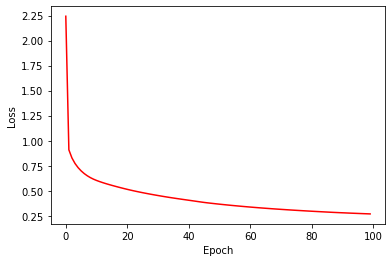

In [ ]:
#Initializing the network (64 units):
mlp_3d = NeuralNetwork(3, 64, 1)

epochs = 100
learning_rate = 1e-4
#Training on 3d train-set
epoch_losses_mlp_3d = []
for iteration in range(epochs):
    loss_epoch = 0
    print('Training epoch '+str(iteration)+'...')
    for indx,x_batch in enumerate(X_3d_batches[:]):
        h = mlp_3d.forward_hidden(x_batch.T)
        y_predict = mlp_3d.forward_output(h)
        loss = mlp_3d.loss_output(y_predict, Y_3d_batches[indx].T)
        loss = np.sum(loss, axis=1)
        loss_epoch += loss
        (dw, db) = mlp_3d.backward_output(h,y_predict,Y_3d_batches[indx].T)
        (dW, dc) = mlp_3d.backward_hidden(x_batch.T, h, y_predict, Y_3d_batches[indx].T,dL_dz=db)
        #Update parameters of network for each batch
        mlp_3d.out_bias = mlp_3d.out_bias - learning_rate*(db)
        mlp_3d.out_weights = mlp_3d.out_weights - learning_rate*(dw)
        mlp_3d.h_bias = mlp_3d.h_bias - learning_rate*(dc.T)
        mlp_3d.h_weights = mlp_3d.h_weights - learning_rate*(dW)
    
    loss_epoch /= data_train.shape[0] #Average loss after each epoch
    print('Loss: '+str(loss_epoch))
    epoch_losses_mlp_3d.append(loss_epoch)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epochs),epoch_losses_mlp_3d,color="red")
plt.show()

Now that the model is trained, we can measure the performance on the test set:

In [ ]:
#Predicting on test set
test_predictions_3d = mlp_3d.forward_output(mlp_3d.forward_hidden(X_3d_test.T))
test_predictions_3d = 1*(test_predictions_3d>0)
correct = 0
for indx,test_prediction in enumerate(test_predictions_3d.T):
    if(float(test_prediction)==Y_3d_test[indx]):
        correct += 1
accuracy = correct/Y_3d_test.shape[0]
print('Test Accuracy: '+str(accuracy))

Test Accuracy: 0.92


We are able to achieve >90% test accuracy on 3-dimensional noisy XOR data using a MLP with 64 hidden units and the softplus loss.

## (g) Classification of Weather dataset
Finally, we will initialize and train an MLP for our weather dataset. In the previous notebook, we fetched weather data from an api and saved it into a csv file to predict rainfall (1=rain, 0=no rain). Since our api key is now expired, we will be unable to fetch the data from the api. However, we saved the weather data into a csv file 'weather.csv', which we will be loading and splitting into train/test sets:

In [ ]:
#Loading weather data csv
from google.colab import drive

drive.mount('/content/drive')
weather_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/weather.csv', usecols=['Max Wind Speed','Avg Cloud Coverage','Humidity','isRain'])
weather_df

Mounted at /content/drive


,Max Wind Speed,Avg Cloud Coverage,Humidity,isRain
0,10.7,51.958333,46.0,0
1,12.3,32.875000,62.0,0
2,19.0,33.208333,53.0,0
3,12.8,20.208333,32.0,0
4,8.9,52.833333,49.0,0
...,...,...,...,...
179,9.2,53.916667,57.0,1
180,11.6,36.083333,63.0,0
181,11.4,24.125000,66.0,0
182,9.4,41.916667,68.0,1


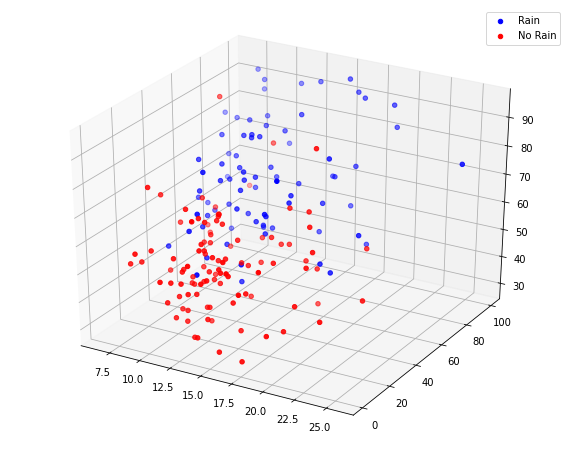

In [ ]:
#Visualizing the dataset
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')
df_class1 = weather_df[weather_df['isRain']==1]
df_class2 = weather_df.drop(df_class1.index)
ax.scatter(df_class1['Max Wind Speed'],df_class1['Avg Cloud Coverage'],df_class1['Humidity'],color='blue',label='Rain')
ax.scatter(df_class2['Max Wind Speed'],df_class2['Avg Cloud Coverage'],df_class2['Humidity'],color='red',label='No Rain')

plt.legend(loc="upper right")
plt.show()

In [ ]:
#Split into train/test sets
cols = weather_df.shape[1]
weather_train = weather_df.sample(frac=0.8, random_state=234)
weather_test = weather_df.drop(weather_train.index)

X_weather_train = weather_train.iloc[:,0:cols-1]
Y_weather_train = weather_train.iloc[:,cols-1:cols]

X_weather_test = weather_test.iloc[:,0:cols-1]
Y_weather_test = weather_test.iloc[:,cols-1:cols]

X_weather_train = np.array(X_weather_train.values)
Y_weather_train = np.array(Y_weather_train.values)
X_weather_test = np.array(X_weather_test.values)
Y_weather_test = np.array(Y_weather_test.values)

#Split into batches
batch_size = 8

q = X_weather_train.shape[0] // batch_size
block_end = q * batch_size

X_weather_batches = np.split(X_weather_train[:block_end], q) + [X_weather_train[block_end:]]
Y_weather_batches = np.split(Y_weather_train[:block_end], q) + [Y_weather_train[block_end:]]
print(X_weather_batches[:1])
print(Y_weather_batches[:1])


[array([[ 7.6       , 21.75      , 74.        ],
       [13.9       , 54.45833333, 55.        ],
       [13.6       , 45.41666667, 60.        ],
       [11.9       , 32.375     , 63.        ],
       [12.3       , 19.54166667, 46.        ],
       [13.4       , 34.        , 57.        ],
       [21.        , 59.45833333, 53.        ],
       [11.2       , 13.79166667, 37.        ]])]
[array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])]


Now we will initialize and train the model. Note that there are 3 features in this dataset, so the input size will be 3. We will be training for 100 epochs again:

Initializing Network...
Hidden Layer weights: [[0.86966656 0.15186183 0.37669134 0.93917238 0.64469741 0.37079804
  0.30095105 0.41042885 0.37491185 0.03294548 0.70381798 0.94404891
  0.95441853 0.62360934 0.49881311 0.43841418 0.73616453 0.45305758
  0.68654791 0.44642532 0.92537307 0.00314461 0.75274783 0.7235752
  0.80937374 0.37447233 0.33208055 0.75593357 0.99506334 0.25233516
  0.1145608  0.87971183 0.93478486 0.15544506 0.21720257 0.89781721
  0.8803988  0.01612518 0.37276814 0.89331507 0.15541124 0.75134151
  0.46974482 0.34346525 0.60733961 0.3755262  0.94624962 0.74875572
  0.83401581 0.05664856 0.35197507 0.66150728 0.09051756 0.68610906
  0.85879761 0.11247414 0.32230956 0.32953605 0.25035158 0.57968371
  0.12591146 0.54940529 0.92083658 0.20619506]
 [0.89427021 0.43852293 0.52829627 0.29426252 0.86010319 0.02783981
  0.79938395 0.15907711 0.20002473 0.92224753 0.464323   0.43943765
  0.37595763 0.87853006 0.47432204 0.85407887 0.23399943 0.15142486
  0.1057295  0.44499979 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in power


Loss: [0.01772173]
Training epoch 50...
Loss: [0.01766783]
Training epoch 51...
Loss: [0.0177028]
Training epoch 52...
Loss: [0.0177313]
Training epoch 53...
Loss: [0.01771269]
Training epoch 54...
Loss: [0.0176621]
Training epoch 55...
Loss: [0.01770591]
Training epoch 56...
Loss: [0.01772863]
Training epoch 57...
Loss: [0.01767541]
Training epoch 58...
Loss: [0.01772751]
Training epoch 59...
Loss: [0.01771956]
Training epoch 60...
Loss: [0.01769998]
Training epoch 61...
Loss: [0.01773456]
Training epoch 62...
Loss: [0.0176808]
Training epoch 63...
Loss: [0.01773262]
Training epoch 64...
Loss: [0.01769316]
Training epoch 65...
Loss: [0.0177459]
Training epoch 66...
Loss: [0.01766657]
Training epoch 67...
Loss: [0.01770287]
Training epoch 68...
Loss: [0.01765616]
Training epoch 69...
Loss: [0.01771178]
Training epoch 70...
Loss: [0.01765734]
Training epoch 71...
Loss: [0.01771353]
Training epoch 72...
Loss: [0.01772641]
Training epoch 73...
Loss: [0.01771177]
Training epoch 74...
Loss:

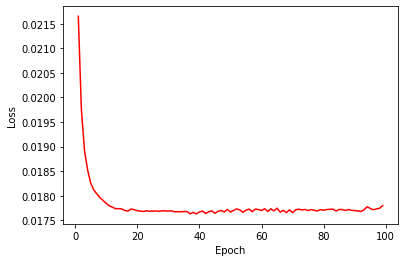

In [ ]:
#Initialize the network
mlp_weather = NeuralNetwork(3, 64, 1)

epochs = 100
learning_rate = 1e-4
#Training on 3d train-set
epoch_losses_mlp_weather = []
for iteration in range(epochs):
    loss_epoch = 0
    print('Training epoch '+str(iteration)+'...')
    for indx,x_batch in enumerate(X_weather_batches[:]):
        h = mlp_weather.forward_hidden(x_batch.T)
        y_predict = mlp_weather.forward_output(h)
        loss = mlp_weather.loss_output(y_predict, Y_weather_batches[indx].T)
        loss = np.sum(loss, axis=1)
        loss_epoch += loss
        (dw, db) = mlp_weather.backward_output(h,y_predict,Y_weather_batches[indx].T)
        (dW, dc) = mlp_weather.backward_hidden(x_batch.T, h, y_predict, Y_weather_batches[indx].T,dL_dz=db)
        #Update parameters of network for each batch
        mlp_weather.out_bias = mlp_weather.out_bias - learning_rate*(db)
        mlp_weather.out_weights = mlp_weather.out_weights - learning_rate*(dw)
        mlp_weather.h_bias = mlp_weather.h_bias - learning_rate*(dc.T)
        mlp_weather.h_weights = mlp_weather.h_weights - learning_rate*(dW)
    
    loss_epoch /= data_train.shape[0] #Average loss after each epoch
    print('Loss: '+str(loss_epoch))
    epoch_losses_mlp_weather.append(loss_epoch)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epochs),epoch_losses_mlp_weather,color="red")
plt.show()

Now that the network is trained, we will evaluate the fit on the test data:

In [ ]:
#Evaluating fit on test set
test_predictions_weather = mlp_weather.forward_output(mlp_weather.forward_hidden(X_weather_test.T))
test_predictions_weather = 1*(test_predictions_weather>0)
correct = 0
for indx,test_prediction in enumerate(test_predictions_weather.T):
    if(float(test_prediction)==Y_weather_test[indx]):
        correct += 1
accuracy = correct/Y_weather_test.shape[0]
print('Test Accuracy: '+str(accuracy))
print('Error Rate: ',(1-accuracy))

Test Accuracy: 0.8108108108108109
Error Rate:  0.18918918918918914


Therefore, we have achieved approximately ~80% accuracy (20% error rate, error rate is just the complement of accuracy) on the weather dataset.